In [ ]:
#@title Copyright 2020 Google LLC. License information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ML 공정성
***

## 목표

* 모델 데이터에서 나타날 수 있는 여러 유형의 편향에 대한 이해도 제고
* 모델을 학습시키기 전에 특성 데이터를 살펴보고 잠재적 데이터 편향 요인을 미리 파악
* 종합집계하는 대신 하위 그룹으로 묶어 모델 성능을 평가

## 개요

머신러닝(ML)에 원치 않는 편향이 발생할 수 있는 방식에 주목하면서 *공정성*을 염두에 두고 데이터세트를 살펴보고 분류자를 평가

공정성에 관한 ML 프로세스의 컨텍스트를 구성할 기회를 제공하는 **FairAware** 작업을 확인. 작업을 진행하는 동안 편향을 파악하고, 이러한 편향이 해결되지 않을 때 발생하는 모델 예측의 장기적인 영향을 고려

## 데이터세트 및 Prediction 작업 정보

Chicago Data Portal의 Transportation 도메인 데이터셋에서 [Traffic Crashes - Crashes 데이터세트](https://data.world/cityofchicago/85ca-t3if)를 활용

\- Source: [Traffic Crashes - Crashes](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if)

\- 원본 데이터세트에서 ML 공정성에 영향을 미칠 수 있는 field만을 임의 선택하여 학습에 사용

\- 원본 데이터세트의 `damage` field 수정 사용
*   `$500 OR LESS`: <=1500
*   `$501 - $1,500`: <=1500
*   `OVER- $1,500`: >1500


### Numeric(수적) Features
*   `posted_speed_limit`: 사고 당시 경찰에 의해 기록 된 차량의 속도 정보

### Categorical(범주적) Features
*   `weather_condition`: 사고 당시 경찰에 의해 기록 된 날씨 정보. 입력값 예시: `CLEAR`, `RAIN` etc.
*   `lighting_condition`: 사고 당시 경찰에 의해 기록 된 조명(밝기) 정보. 입력값 예시: `DAYLIGHT`, `DARKNESS`, `DARKNESS LIGHTED ROAD` etc.
*   `roadway_surface_cond`: 사고 당시 경찰에 의해 기록 된 사고지점 노면의 상태 정보. 입력값 예시: `DRY`, `ICE`, `WET` etc.
*   `first_crash_type`:  사고 당시 경찰에 의해 기록 된 사고타입 정보. 입력값 예시: `REAR EDN`, `TURNING`, `ANGLE`, `PARKED MOTOR VEHICLE` etc.

### Prediction 작업
예측 작업은 **교통 사고 수리비가 미화 $1,500 초과인지 확인**하기 위해 실행

### Label
*   `damage`: 교통 사고 수비리가 $1,500 넘는지 여부를 나타냄

## Setup

Run on TensorFlow 2.x.

In [ ]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

* This setup code cell also installs [Facets](https://pair-code.github.io/facets/)

* An open-source tool created by [PAIR](https://research.google/teams/brain/pair/) that contains two robust visualizations we'll be using to aid in understanding and analyzing ML datasets.

In [ ]:
#@title Import revelant modules and install Facets
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

from google.colab import widgets
# For facets
from IPython.core.display import display, HTML
import base64
!pip install facets-overview==1.0.0
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

### Load the Traffic Crashes - Crashes Dataset



In [ ]:
COLUMNS = ["posted_speed_limit", "weather_condition", "lighting_condition", "first_crash_type", 
           "roadway_surface_cond", "damage"]

train_csv = tf.keras.utils.get_file('crashes.data', 
  'http://164.125.37.222:18099/data/201008/201008_origin_122219624.csv') #before
  # 'http://164.125.37.222:18099/data/201008/201008_origin_123605402.csv') #after
test_csv = tf.keras.utils.get_file('crashes.data', 
  'http://164.125.37.222:18099/data/201008/201008_testset.csv')

train_df = pd.read_csv(train_csv, names=COLUMNS, sep=r'\s*,\s*', 
                       engine='python', na_values="?")
test_df = pd.read_csv(test_csv, names=COLUMNS, sep=r'\s*,\s*', skiprows=[0],
                      engine='python', na_values="?")

print('train rows: ', train_df.shape[0], ' cells: ', train_df.shape[1])

1490944/1490538 [==============================] - 1s 1us/step
train rows:  32000  cells:  6


## Analyzing the Traffic Crashes - Crashes Dataset with Facets

To start, we can use [Facets Overview](https://pair-code.github.io/facets/), an interactive visualization tool that can help us explore the dataset. With Facets Overview, we can quickly analyze the distribution of values across the Traffic Crashes - Crashes dataset.

In [ ]:
#@title Visualize the Data in Facets
fsg = FeatureStatisticsGenerator()
dataframes = [
    {'table': train_df, 'name': 'trainData'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")


HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

### FairAware 작업 #1

* 각 수적 특성 및 연속 특성의 기술 통계량과 히스토그램을 검토
* 범주형 특성의 히스토그램 위에 있는 **SHOW RAW DATA** 를 클릭하여 범주별 값 분포를 확인

### Visualize in Facets Dive

* 데이터세트를 더 자세히 살펴보기 위해 [Facets Dive](https://pair-code.github.io/facets/)를 사용
* 시각화된 개별 항목이 하나의 데이터 포인트를 나타내는 대화형 인터페이스 제공

In [ ]:
#@title Set the Number of Data Points to Visualize in Facets Dive

SAMPLE_SIZE = 5000 #@param
  
train_dive = train_df.sample(SAMPLE_SIZE).to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=train_dive)
display(HTML(html))

## FairAware 작업 #2

공정성 관련사항 검토
* 누락된 특성
* 지나치게 일반화 된 특성
* 충분히 대표되지 않은 특성

### FairAware 작업 #3

공정성에 영향을 미칠 수 있는 특성에 대한 입력

In [ ]:
feature = 'posted_speed_limit / weather_condition / lighting_condition' 

print('done')

done


## Predicting income using the Keras API 



### Convert Traffic Crashes - Crashes Dataset into Tensors


In [ ]:
def pandas_to_numpy(data):
  '''Convert a pandas DataFrame into a Numpy array'''
  # Drop empty rows.
  data = data.dropna(how="any", axis=0)

  # Separate DataFrame into two Numpy arrays"
  labels = np.array(data['damage'] == ">1500")
  features = data.drop('damage', axis=1)
  features = {name:np.array(value) for name, value in features.items()}
  
  return features, labels

### Represent Features in TensorFlow
* 데이터가 모델에 매핑되기 위해 'tf.feature_columns' 를 사용하여 텐서플로우에서 특성을 처리하고 표현

In [ ]:
#@title Create categorical feature columns

# Since we don't know the full range of possible values with occupation and
# native_country, we'll use categorical_column_with_hash_bucket() to help map
# each feature string into an integer ID.

first_crash_type = tf.feature_column.categorical_column_with_hash_bucket(
    "first_crash_type", hash_bucket_size=1000)

# For the remaining categorical features, since we know what the possible values
# are, we can be more explicit and use categorical_column_with_vocabulary_list()

weather_condition = tf.feature_column.categorical_column_with_vocabulary_list(
    "weather_condition", ["CLEAR", "RAIN"])
lighting_condition = tf.feature_column.categorical_column_with_vocabulary_list(
    "lighting_condition", ["DARKNESS", "DARKNESS LIGHTED ROAD", "DAWN", 
                           "DAYLIGHT", "DUSK", "UNKNOWN"])
roadway_surface_cond = tf.feature_column.categorical_column_with_vocabulary_list(
    "roadway_surface_cond", ["DRY", "ICE", "OTHER", "SAND/MUD/DIRT", 
                             "SNOW OR SLUSH", "UNKNOWN", "WET"])

In [ ]:
#@title Create numeric feature columns
# For Numeric features, we can just call on feature_column.numeric_column()
# to use its raw value instead of having to create a map between value and ID.

posted_speed_limit = tf.feature_column.numeric_column("posted_speed_limit")

#### 기록 된 사고당시 차량의 속도를 Categorical(범주형) Feature로 만들기


In [ ]:
posted_speed_limit_buckets = tf.feature_column.bucketized_column(
    posted_speed_limit, boundaries=[10, 20, 30, 40, 50, 60, 70, 80])

### 모델 특성 정의

모델에 포함할 특성을 명시적으로 정의

`weather_condition`을 하위 그룹으로 고려하고 별도의 `subgroup_variables` 목록에 저장하므로 필요한 경우 특수 처리 추가할 수 있음

In [ ]:
# List of variables, with special handling for gender subgroup.

variables = [first_crash_type, lighting_condition, roadway_surface_cond, posted_speed_limit_buckets]
subgroup_variables = [weather_condition]
feature_columns = variables + subgroup_variables

### Train a Deep Neural Net Model on Traffic Crashes - Crashes Dataset

In [ ]:
deep_columns = [   
    tf.feature_column.indicator_column(posted_speed_limit_buckets),
    tf.feature_column.indicator_column(weather_condition),
    tf.feature_column.indicator_column(first_crash_type),
    tf.feature_column.indicator_column(lighting_condition),
    tf.feature_column.indicator_column(roadway_surface_cond),    
]

In [ ]:
#@title Define Deep Neural Net Model

# Parameters from form fill-ins
HIDDEN_UNITS_LAYER_01 = 128 #@param
HIDDEN_UNITS_LAYER_02 = 64 #@param
LEARNING_RATE = 0.1 #@param
L1_REGULARIZATION_STRENGTH = 0.001 #@param
L2_REGULARIZATION_STRENGTH = 0.001 #@param

RANDOM_SEED = 512
tf.random.set_seed(RANDOM_SEED)

# List of built-in metrics that we'll need to evaluate performance.
METRICS = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'), 
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='auc'),
]

regularizer = tf.keras.regularizers.l1_l2(
    l1=L1_REGULARIZATION_STRENGTH, l2=L2_REGULARIZATION_STRENGTH)

model = tf.keras.Sequential([
  layers.DenseFeatures(deep_columns),
  layers.Dense(
      HIDDEN_UNITS_LAYER_01, activation='relu', kernel_regularizer=regularizer),
  layers.Dense(
      HIDDEN_UNITS_LAYER_02, activation='relu', kernel_regularizer=regularizer),
  layers.Dense(
      1, activation='sigmoid', kernel_regularizer=regularizer)
])

model.compile(optimizer=tf.keras.optimizers.Adagrad(LEARNING_RATE),  
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [ ]:
#@title Fit Deep Neural Net Model to the Traffic Crashes - Crashes Training Dataset

EPOCHS = 10 #@param
BATCH_SIZE = 500 #@param
features, labels = pandas_to_numpy(train_df)
model.fit(x=features, y=labels, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
64/64 [==============================] - 1s 14ms/step - loss: 5.0161 - tp: 8524.0000 - fp: 6713.0000 - tn: 9287.0000 - fn: 7476.0000 - accuracy: 0.5566 - precision: 0.5594 - recall: 0.5328 - auc: 0.5770
Epoch 2/10
64/64 [==============================] - 1s 14ms/step - loss: 2.7307 - tp: 8252.0000 - fp: 6271.0000 - tn: 9729.0000 - fn: 7748.0000 - accuracy: 0.5619 - precision: 0.5682 - recall: 0.5157 - auc: 0.5895
Epoch 3/10
64/64 [==============================] - 1s 14ms/step - loss: 1.4050 - tp: 7659.0000 - fp: 5552.0000 - tn: 10448.0000 - fn: 8341.0000 - accuracy: 0.5658 - precision: 0.5797 - recall: 0.4787 - auc: 0.5911
Epoch 4/10
64/64 [==============================] - 1s 13ms/step - loss: 0.9491 - tp: 7364.0000 - fp: 5411.0000 - tn: 10589.0000 - fn: 8636.0000 - accuracy: 0.5610 - precision: 0.5764 - recall: 0.4602 - auc: 0.5876
Epoch 5/10
64/64 [==============

Evalute the overall model's performance using the test set

In [ ]:
#@title Evaluate Deep Neural Net Performance

features, labels = pandas_to_numpy(test_df)
model.evaluate(x=features, y=labels);

print('done')

Consider rewriting this model with the Functional API.
1000/1000 [==============================] - 3s 3ms/step - loss: 0.7176 - tp: 6559.0000 - fp: 4249.0000 - tn: 11750.0000 - fn: 9441.0000 - accuracy: 0.5722 - precision: 0.6069 - recall: 0.4099 - auc: 0.5953
done


## Evaluating for Fairness Using a Confusion Matrix

### Plot the Confusion Matrix



In [ ]:
#@title Define Function to Visualize Binary Confusion Matrix
def plot_confusion_matrix(
    confusion_matrix, class_names, subgroup, figsize = (8,6)):
  # We're taking our calculated binary confusion matrix that's already in the 
  # form of an array and turning it into a pandas DataFrame because it's a lot 
  # easier to work with a pandas DataFrame when visualizing a heat map in 
  # Seaborn.
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names, 
  )

  rcParams.update({
  'font.family':'sans-serif',
  'font.sans-serif':['Liberation Sans'],
  })
  
  sns.set_context("notebook", font_scale=1.25)

  fig = plt.figure(figsize=figsize)

  plt.title('Confusion Matrix for Performance Across ' + subgroup)

  # Combine the instance (numercial value) with its description
  strings = np.asarray([['True Positives', 'False Negatives'],
                        ['False Positives', 'True Negatives']])
  labels = (np.asarray(
      ["{0:g}\n{1}".format(value, string) for string, value in zip(
          strings.flatten(), confusion_matrix.flatten())])).reshape(2, 2)

  heatmap = sns.heatmap(df_cm, annot=labels, fmt="", 
      linewidths=2.0, cmap=sns.color_palette("GnBu_d"));
  heatmap.yaxis.set_ticklabels(
      heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  heatmap.xaxis.set_ticklabels(
      heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
  plt.ylabel('References')
  plt.xlabel('Predictions')
  return fig

### FairAware 작업 #4


,TPR=TP/(TP+FN),FNR=FN/(TP+FN)
RAIN,0.6097,0.3903


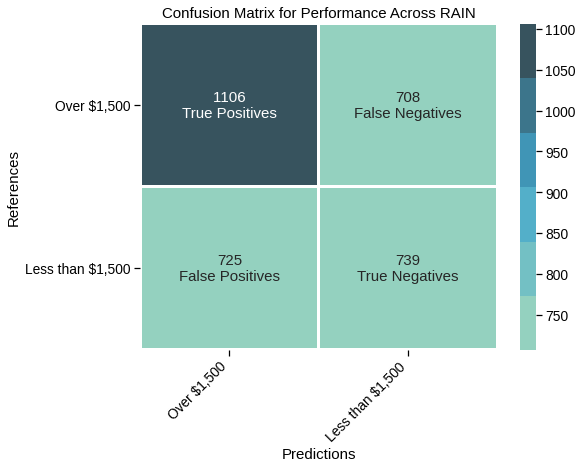

In [ ]:
#@title Visualize Binary Confusion Matrix and Compute Evaluation Metrics Per Subgroup
CATEGORY  =  "weather_condition" #@param {type:"string"}
SUBGROUP =  "RAIN" #@param {type:"string"}

# Labels for annotating axes in plot.
classes = ['Over $1,500', 'Less than $1,500']

# Given define subgroup, generate predictions and obtain its corresponding 
# ground truth.
subgroup_filter  = test_df.loc[test_df[CATEGORY] == SUBGROUP]
features, labels = pandas_to_numpy(subgroup_filter)
subgroup_results = model.evaluate(x=features, y=labels, verbose=0)
confusion_matrix = np.array([[subgroup_results[1], subgroup_results[4]], 
                             [subgroup_results[2], subgroup_results[3]]])

# subgroup_performance_metrics = {
#     'ACCURACY': subgroup_results[5],
#     'PRECISION': subgroup_results[6], 
#     'RECALL': subgroup_results[7],
#     'AUC': subgroup_results[8]
# }

subgroup_performance_metrics = {
    # 'ACCURACY': subgroup_results[5],
    # 'PRECISION': subgroup_results[6], 
    'TPR=TP/(TP+FN)': subgroup_results[7],
    'FNR=FN/(TP+FN)': 1-subgroup_results[7]
}
performance_df = pd.DataFrame(subgroup_performance_metrics, index=[SUBGROUP])
pd.options.display.float_format = '{:,.4f}'.format

plot_confusion_matrix(confusion_matrix, classes, SUBGROUP);
performance_df

## Summary (Fairness indicator)

### 1. 균등 기회 (Equal Opportunity)

- definition: 보호 그룹과 보호되지 않은 그룹은 동일한 참긍정(True Positive)의 비율을 가져야 함
- `damage` field 에서 미화 1,500 달러 이하와 미화 1,500 달러 초과 확인을 위한 Prediction
- Category `weather_condition` 중 Subgroup `CLEAR` 입력에 따른 TPR과 Subgroup `RAIN` 입력에 따른 TPR 이 같아야만 균등 기회(Equal Opportunity)를 만족


### 2. 균등 승률 (Equalized odds)

- definition: 보호된 그룹과 보호되지 않은 그룹은 참긍정(True Positive)과 오탐지(False Negative)에 대해 동일한 비율을 가져야 함
- `damage` field 에서 미화 1,500 달러 이하와 미화 1,500 달러 초과 확인을 위한 Prediction
- Category `weather_condition` 중 Subgroup `CLEAR` 입력에 따른 TPR, FNR 과 Subgroup `RAIN` 입력에 따른 TPR, FNR 이 같아야만 균등 승률(Equalized odds)을 만족